In [41]:
from goessolarretriever import Retriever, Satellite, Product
from datetime import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

satellite = Satellite.GOES18
start = datetime(2024, 10, 3); end = datetime(2024, 10, 3)

r = Retriever()
for product in [Product.xrsf_l2_avg1m,Product.euvs_l2_avg1m]:
    df = r.search(satellite, product, start, end)
    df['date_begin'] = pd.to_datetime(df['file_name'].str.extract(r".*_d(\d{8})_.*").iloc[:,0],format='%Y%m%d')
    df = df.set_index('date_begin',drop=False).sort_index()
    df = df[(df.index >= start) & (df.index <= end)]
    r.retrieve(df, f"{product}/data/")
    df.to_csv(f"{product}/files.csv")

1it [00:01,  1.85s/it]
1it [00:01,  1.45s/it]


In [43]:
xrsas = []; xrsbs = []
for date,row in pd.read_csv('Product.xrsf_l2_avg1m/files.csv').iterrows():
    ds = xr.load_dataset("Product.xrsf_l2_avg1m/data/"+row.file_name)
    xrsas.append(ds.xrsa_flux)
    xrsbs.append(ds.xrsb_flux)

In [72]:
euvs_data = {v:[] for v in ['irr_256', 'irr_284', 'irr_304', 'irr_1175', 'irr_1216', 'irr_1335', 'irr_1405']}
for date,row in pd.read_csv('Product.euvs_l2_avg1m/files.csv').iterrows():
    ds = xr.load_dataset("Product.euvs_l2_avg1m/data/"+row.file_name)
    for v,l in euvs_data.items():
        l.append(ds[v])

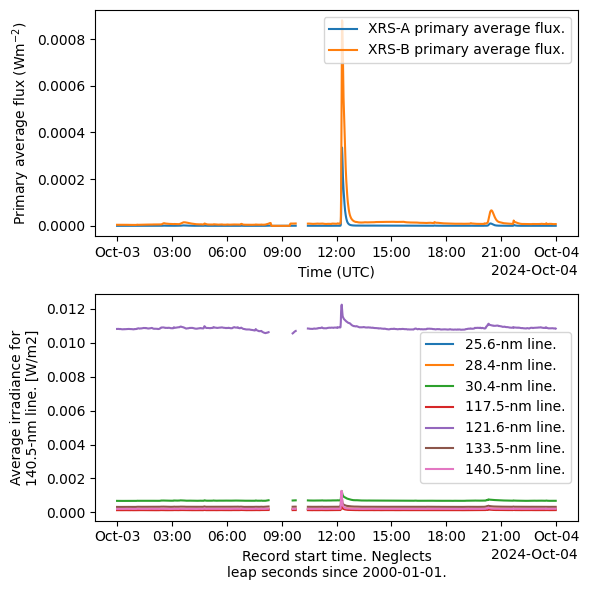

In [ ]:
fig, axes = plt.subplots(2,figsize=(6,6))
xr.concat(xrsas,'time').plot(ax=axes[0],label=xrsas[0].long_name)
xr.concat(xrsbs,'time').plot(ax=axes[0],label=xrsbs[0].long_name)
axes[0].set_xlabel(r'Time (UTC)')
axes[0].set_ylabel(r'Primary average flux ($\mathrm{W m^{-2}}$)')
axes[0].legend()
for l in euvs_data.values():
    xr.concat(l,'time').plot(ax=axes[1],label=' '.join(l[0].long_name.split(' ')[-2:]))
axes[1].legend()
axes[0].set_xlabel(r'Time (UTC)')
axes[0].set_ylabel(r'Average irradiance ($\mathrm{W m^{-2}}$)')
fig.tight_layout()